# Preprocess stock data


**Context**: Check duplicates, missing data, outliers of stock data


# Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr

# Loading stock data (stored locally)


In [2]:
def load_stock_data_locally(path:str) -> pd.DataFrame:
    '''
    This function receives a path (string) indicating where the stock data is stored locally.
    - It loads the stock data as csv file.
    - It takes Date column as index.
    - It transforms the index into Date time index.
    It returns it as a Pandas Dataframe.
    '''
    stock = pd.read_csv(path, index_col='Date')
    stock.index = pd.to_datetime(stock.index)
    return stock

In [3]:
# Retrieve stock data based on ticker and store it locally
ticker='AAPL'
path_ticker = f"../data/raw_data/{ticker}.csv"

df = load_stock_data_locally(path_ticker)
df.head()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2023-02-14,151.670441,152.234757,149.353807,150.601222,61707600
2023-02-15,153.779190,153.947491,151.353654,151.581353,65573800
2023-02-16,152.175339,154.769175,151.818932,151.977323,68167900
2023-02-17,151.026932,151.472436,149.343908,150.828932,59144100
2023-02-21,146.997559,149.789411,146.928265,148.700387,58867200


# Check duplicates


In [4]:
def drop_time_series_duplicates(df:pd.DataFrame):
    '''
    This function gets a Pandas Dataframe as input, and drops duplicates rows if any.
    The index of the input dataframe is related to a date, or duration mark.
    '''
    if df.reset_index().duplicated().sum() > 0 : 
        nb_duplicates = df.reset_index().duplicated().sum()
        df.drop_duplicates()
        print(f'{nb_duplicates} have been dropped !')
    else:
        print('No duplicates found !')
    
    return df

In [5]:
# Drop duplicates, if any.
df = drop_time_series_duplicates(df)

No duplicates found !


# Check missing data


In [6]:
def get_missing_data(data: pd.DataFrame):  
    '''
    This function gets a Pandas Dataframe as input.
    Returns the percentage of missing values per column, if any.
    '''

    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent    
    return missing_data

In [7]:
# Check missing data, if any
get_missing_data(df)

Series([], dtype: float64)

# Check outliers


## Visually

In [8]:
def plot_hist_box(df:pd.DataFrame):
    '''
    This function receives a Pandas Dataframe.
    - It selects the numerical features in the input dataframe.
    - It plots histograms and boxplots for each numerical feature of input dataframe.
    '''     
    # Numerical Features
    numerical_features = df.select_dtypes(include = 'number').columns.values.tolist()

    #Parameters     
    ncol_max = 2
    nrow_max = len(numerical_features)   
    
    #Figure settings
    fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(15, 14))

    # Flatten axes for easy iteration
    axs = axs.flatten()
    
    #Parameter to index axs     
    ax_index = 0
    
    for col in numerical_features:  
        # Plotting the histograms
        sns.histplot(data = df[numerical_features], x= col, kde = True, ax=axs[ax_index], bins = 50)   

        # Plotting the boxplots
        sns.boxplot(data = df[numerical_features], x= col, ax=axs[ax_index+1])
        
        # Formatting
        axs[ax_index].set_xlabel(col)
        axs[ax_index].set_title(f'Hist Plot - {col}')  
        axs[ax_index+1].set_xlabel(col)
        axs[ax_index+1].set_title(f'Box Plot - {col}')  

        # Incrementing
        ax_index +=2
        
        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)

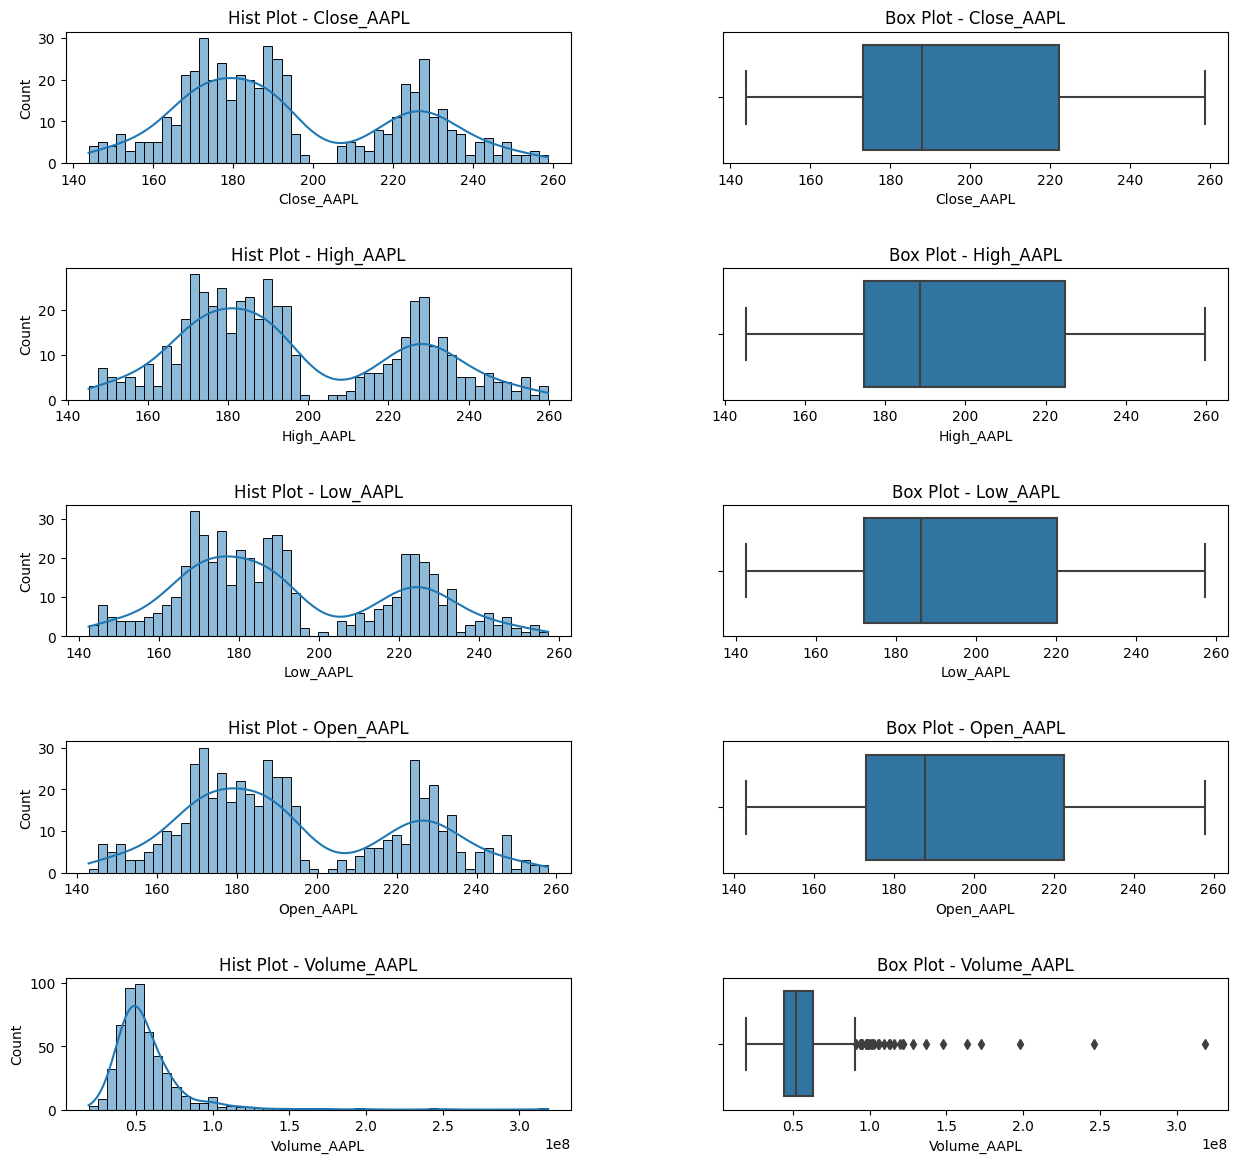

In [9]:
# Histograms and boxplots of stock data
plot_hist_box(df)

## Computationnally



In [10]:
def find_outliers(df:pd.DataFrame):
    '''
    This function receives a Pandas Dataframe.
    - It calculates the Inter Quartile Range (IQR), 1st quartile, 3rd quartile.
    - Then it calculates the limits beyond which a value is considered an outlier (i.e q +/- 1.5 * iqr_value)
    - It computes, for each feature, the number of outliers.
    - It appends the feature name into 1 of 2 lists : list of features WITH outliers or list of features WITHOUT outliers.
    This function retruns 2 lists.    
    '''
    
    # Identify the columns with outliers
    numerical_columns_w_outliers = []
    numerical_columns_no_outliers = []
    
    # Numerical Features
    numerical_features = df.select_dtypes(include = 'number').columns.values.tolist()
    
    for col in numerical_features: 
        # Calculate IQR
        iqr_value = iqr(df[col])
        
        #Calculate 1st quartile
        q1 = np.percentile(df[col],25)
        
        #Calculate 3rd quartile
        q3 = np.percentile(df[col],75)
        
        #Calculate lower limit below which data point is considered an outlier
        outlier_lim_low = q1 - 1.5 * iqr_value
        
        #Calculate higher limit above which data point is considered an outlier
        outlier_lim_high = q3 + 1.5 * iqr_value
        
        #Calculate number of 'low' outliers
        outlier_condition_low = df[col] < outlier_lim_low
        number_outliers_low = len(df[outlier_condition_low][col])
        
        #Calculate number of 'high' outliers
        outlier_condition_high = df[col] > outlier_lim_high
        number_outliers_high = len(df[outlier_condition_high][col])
        
        #Calculate total number of outliers
        number_outliers_total = number_outliers_low + number_outliers_high

        #If any outliers in column, column is added to a list of columns with outliers
        if number_outliers_total > 0:
            numerical_columns_w_outliers.append(col)
        else:
            numerical_columns_no_outliers.append(col)

    return numerical_columns_w_outliers, numerical_columns_no_outliers

In [11]:
# Check for outliers in data stock features
cols_outliers, cols_no_outliers = find_outliers(df)

print(f"Columns with outliers : {cols_outliers}")
print(f"Columns with NO outliers : {cols_no_outliers}")

Columns with outliers : ['Volume_AAPL']
Columns with NO outliers : ['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL']
